<font size="7">**Graph PCA**</font>

[![Generate README](https://github.com/YertleTurtleGit/graph-pca/actions/workflows/readme.yml/badge.svg)](https://github.com/YertleTurtleGit/graph-pca/actions/workflows/readme.yml)
<a target="_blank" href="https://colab.research.google.com/github/YertleTurtleGit/graph-pca/blob/main/README.ipynb">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Performs PCA with optional graph distance for neighborhood composition.

(Still under heavy development.)

<!-- START doctoc -->
<!-- END doctoc -->


# Installation

In [4]:
BUILD_BY_YOURSELF = True

if BUILD_BY_YOURSELF:
    !pip install maturin
    !maturin develop
else:
    !pip install -q git+https://github.com/YertleTurtleGit/graph-pca

⚠️  Warning: You specified maturin ==1.3.2 in pyproject.toml under `build-system.requires`, but the current maturin version is 1.4.0
🔗 Found pyo3 bindings
🐍 Found CPython 3.10 at /home/yertle/Documents/graph-pca/.venv/bin/python
   Compiling pyo3-build-config v0.20.0
   Compiling pyo3-ffi v0.20.0========>   ] 86/94: pyo3-build-config           
   Compiling pyo3 v0.20.0
   Compiling graph_pca v0.1.0 (/home/yertle/Documents/graph-pca)              
   --> src/graph_pca_lib.rs:235:17
    |
235 |             let pca = get_pca(&eigenvalues);
    |                 ^^^ help: if this is intentional, prefix it with an underscore: `_pca`
    |
    = note: `#[warn(unused_variables)]` on by default

error[E0596]: cannot borrow `feature_vectors` as mutable, as it is a captured variable in a `Fn` closure
   --> src/graph_pca_lib.rs:224:54
    |
224 | ... features.iter().enumerate().for_each(|(feature_index, _)| {
    |                                          ^^^^^^^^^^^^^^^^^^^^ cannot borrow as m

# Examples

## Image

In [2]:
!pip install -q numpy opencv-python matplotlib requests

In [3]:
import requests
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import graph_pca

In [20]:
from graph_pca import Feature

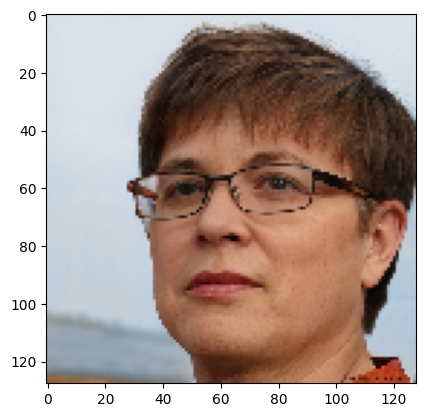

In [21]:
image_url = "http://thispersondoesnotexist.com/"
image = np.asarray(bytearray(requests.get(image_url).content), dtype=np.uint8)
image = cv.imdecode(image, cv.IMREAD_COLOR)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image = cv.resize(image, (128, 128))
h, w, c = image.shape

_ = plt.imshow(image)

In [22]:
image = image.astype(np.float64) / 255
h, w, c = image.shape

radius = 0.1
max_edge_length = (
    radius  # this ignores graph distance, because max_edge_length >= radius
)

In [ ]:
feature_count = c
image_vectors = image.reshape((w * h, feature_count))

features = [
    Feature.Eigenvalues,
    Feature.PrincipalComponentValues
]

print(str(Feature.PrincipalComponentValues))

eigenvalues, pca = graph_pca.calculate_features(
    image_vectors, features, radius, max_edge_length
)

### Number of Neighbors

Here we simply count the number of neighbors in the feature space. Thus, brighter pixels have more similar pixels within the whole image.

In [ ]:
feature_count = c
image_vectors = image.reshape((w * h, feature_count))

number_of_neighbors = graph_pca.calculate_number_of_neighbors(
    image_vectors, radius, max_edge_length
)
number_of_neighbors = np.array(number_of_neighbors)

_ = plt.imshow(number_of_neighbors.reshape(h, w))

Now, we add the pixel location in the image as a feature and count the neighbors again. That results in some sort of edge finding algorithm: The brighter the pixel, the more similar pixels are close.

In [ ]:
# This adds the pixel coordinates as features
grid = np.array(np.meshgrid(np.linspace(0, 1, w), np.linspace(0, 1, h)))
image_xy = np.dstack(
    [image[:, :, 0], image[:, :, 1], image[:, :, 2], grid[0, :, :], grid[1, :, :]]
)

# Transform the image in an array with 5 normalized features per data point: RGB+XY
feature_count_xy = c + 2
image_xy_vectors = image_xy.reshape((w * h, feature_count_xy))
# radius *= feature_count_xy / feature_count

number_of_neighbors_xy = graph_pca.calculate_number_of_neighbors(
    image_xy_vectors, radius, max_edge_length
)
number_of_neighbors_xy = np.array(number_of_neighbors_xy)

_ = plt.imshow(number_of_neighbors_xy.reshape(h, w))

### Eigenvalues

In [ ]:
eigenvalues = graph_pca.calculate_eigenvalues(image_vectors, radius, max_edge_length)
eigenvalues = np.array(eigenvalues).reshape(h, w, feature_count)

variance = np.prod(eigenvalues, axis=2) ** (1 / eigenvalues.shape[2])
eigenvalue_sum = np.sum(eigenvalues, axis=2)

figure, axes = plt.subplots(1, 2, figsize=(3 * 2, 3))
axes[0].set_title("Variance")
_ = axes[0].imshow(variance)
axes[1].set_title("Eigenvalue Sum")
_ = axes[1].imshow(eigenvalue_sum)

In [ ]:
eigenvalues = graph_pca.calculate_eigenvalues(image_xy_vectors, radius, max_edge_length)
eigenvalues = np.array(eigenvalues).reshape(h, w, feature_count_xy)

variance = np.prod(eigenvalues, axis=2) ** (1 / eigenvalues.shape[2])
eigenvalue_sum = np.sum(eigenvalues, axis=2)

figure, axes = plt.subplots(1, 2, figsize=(3 * 2, 3))
axes[0].set_title("Local Variance")
_ = axes[0].imshow(variance)
axes[1].set_title("Local Eigenvalue Sum")
_ = axes[1].imshow(eigenvalue_sum)